In [149]:
import pandas as pd
import numpy as np

import sklearn as sklearn

from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import random


# Exploratory Data Analysis

Steps:
- cleaning & removing NaN occurrences
- dropping columns to remove multicolinearity and redundancy in the data
- one-hot encoding all factor variables to r-1 columns, given a factor vairable that has r states -> didn't work!     
- the origin and deistination vairables can fall into *A LOT* of classes, which when one-hot encoded, increases the dimensionality to ~430 columns!
- even after running PCA on this data, no linear model was converging to fit the data due to the high dimensions from the one hot encoding
- eventually encoded the classifiers in an ordinal encoding

First we will clean our dataset by removing the NaN values. One alternative solution would be to synthetically fill in the NaN values for certain columns based on the relationships between the predictors, but (a) this can be tricky as to not produce a sample of synthetic data that does not represent the true population well and (b) with large amounts of data, eliminating NaN values should be sufficient for our purposes. We will remove rows that contain a NaN value, but since some columns contain a large amount of NaN values, we will remove some columns entirely before removing rows. 

Next we will remove columns and predictors that are redundant. At a first glance, I see that there are multiple columns for origin and destination that express a single metric. These redundant columns will be removed. 

Finally we'll need to encode the factor variables. As explained above, the one-hot encoding method produced a very high dimensional dataset, so an ordinal encoding was applied instead using the mean delay time for each class. 

### Retrospective Note

When I first completed my EDA and looked at the scatterplot of delay time and the predictor, I saw that the below predictors were HIGHLY correlated with delay time. After conducting my dimensionality reduction, model building, testing, and importance analysis, I saw that the models were able to achieve ~95% classification accuracies and ~0.95 for their r squared values. However, when I looked at the graphs of feature importance, I saw they were almost exclusivley dependent on the below features. Logically this easily makes sense, as the dely time can only be greater than or equal to the sum of the delays. 

But from a business perspective on reducing and predicting flight delays, this is not very insightful. These flags for delays are produced when the decision to delay the flight is made, so obviously it would be a good predictor of delay time. In terms of finding predictors that have a causal relationship with delay time and providing insights on how to predict and reduce delay time for future flights, knowing that the delay time is closley related to the below features is useless. Thus after noting the model's dependence on the following features, I dropped those columns in my EDA and re-ran my models on the new dataset. The result was lower accuracy as excpected, but a more even distribution of importance amoung the features. 


'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'

In [150]:
pd.set_option('display.max_columns', None)
raw_data = pd.read_csv('fa23_datachallenge.csv')

In [151]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890644 entries, 0 to 890643
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          890644 non-null  int64  
 1   DAY_OF_MONTH                   890644 non-null  int64  
 2   DAY_OF_WEEK                    890644 non-null  int64  
 3   OP_UNIQUE_CARRIER              890644 non-null  object 
 4   TAIL_NUM                       888500 non-null  object 
 5   OP_CARRIER_FL_NUM              890644 non-null  int64  
 6   ORIGIN_AIRPORT_ID              890644 non-null  int64  
 7   ORIGIN_AIRPORT_NAME            741160 non-null  object 
 8   ORIGIN                         890644 non-null  object 
 9   ORIGIN_CITY_NAME               890644 non-null  object 
 10  DEST_AIRPORT_ID                890644 non-null  int64  
 11  DEST                           890644 non-null  object 
 12  DEST_CITY_NAME                

In [152]:

raw_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_NAME,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,PSUN,TSUN,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
0,6,8,6,AA,N186US,1216,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",11057,CLT,"Charlotte, NC",839,839.0,0.0,0.0,0800-0859,1215,1217.0,2.0,1200-1259,0.0,NaN,156.0,158.0,936.0,4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,69.0,92.0,NaN,6.04,NaN,NaN,25390.0,76419.0,12632.0,2907365.0,11744595.0,0.000098,0.000177
1,5,19,7,OO,N445SW,3643,11823,NaN,FWA,"Fort Wayne, IN",10397,ATL,"Atlanta, GA",800,755.0,0.0,0.0,0800-0859,956,942.0,0.0,0900-0959,0.0,NaN,116.0,107.0,508.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,18,3,MQ,N226NN,3303,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",10781,BTR,"Baton Rouge, LA",2220,2219.0,0.0,0.0,2200-2259,2340,2334.0,0.0,2300-2359,0.0,NaN,80.0,75.0,383.0,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,29.0,58.0,NaN,3.36,NaN,NaN,25322.0,26721.0,5416.0,2907365.0,1204766.0,0.000348,0.000107
3,1,2,3,YX,N408YX,4697,10785,NaN,BTV,"Burlington, VT",11278,DCA,"Washington, DC",556,553.0,0.0,0.0,0001-0559,759,753.0,0.0,0700-0759,0.0,NaN,123.0,120.0,437.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,21,4,DL,N986AT,2639,14771,San Francisco International,SFO,"San Francisco, CA",12892,LAX,"Los Angeles, CA",1226,1229.0,3.0,0.0,1200-1259,1351,1351.0,0.0,1300-1359,0.0,NaN,85.0,82.0,337.0,2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,46.0,61.0,53.0,7.61,NaN,NaN,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149


In [153]:
raw_data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,PSUN,TSUN,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
count,890644.000000,890644.000000,890644.000000,890644.000000,890644.000000,890644.000000,890644.000000,874989.000000,874983.000000,874983.000000,890644.000000,874080.000000,872065.000000,890644.000000,890630.000000,872065.000000,890644.000000,890644.000000,166733.000000,166733.000000,166733.000000,166733.000000,166733.000000,740952.000000,535313.000000,517691.000000,740966.000000,741017.000000,640960.000000,741088.000000,2158.000000,2119.000000,744781.000000,744781.000000,744781.000000,7.447810e+05,7.447810e+05,744781.000000,744781.000000
mean,6.582800,15.729693,3.935111,2557.051234,12646.741929,12647.394874,1329.663311,1334.092043,14.140627,0.186856,1485.655636,1462.588732,14.186835,0.018237,141.814290,136.580028,799.900916,3.674111,21.164227,3.799392,16.692976,0.092837,27.382750,0.104146,0.056713,0.159976,52.139012,70.667425,60.850515,8.343487,36.887859,286.240208,12661.699454,63378.814653,3448.589969,1.595160e+06,7.904560e+06,0.000099,0.000136
std,3.403242,8.761630,1.994265,1798.793938,1523.321634,1523.348525,493.011624,507.228246,48.149006,0.389796,521.494959,542.642179,47.864388,0.133809,72.198188,72.435543,591.297775,2.328900,66.801931,32.626654,40.625763,2.879271,52.657293,0.310208,0.446041,0.987789,17.510117,18.769882,17.786419,3.653206,35.556643,281.531713,9093.783252,34179.832079,4350.140219,1.155475e+06,5.013258e+06,0.000087,0.000047
min,1.000000,1.000000,1.000000,1.000000,10135.000000,10135.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,20.000000,15.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-26.000000,-10.000000,-18.000000,0.000000,0.000000,0.000000,1100.000000,5582.000000,1.000000,7.047600e+04,4.737940e+05,0.000000,0.000007
25%,4.000000,8.000000,2.000000,1027.000000,11292.000000,11292.000000,913.000000,914.000000,0.000000,0.000000,1100.000000,1046.000000,0.000000,0.000000,90.000000,84.000000,369.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,58.000000,48.000000,5.820000,2.000000,10.000000,4956.000000,25142.000000,599.000000,6.142360e+05,2.884187e+06,0.000034,0.000099
50%,7.000000,16.000000,4.000000,2158.000000,12889.000000,12889.000000,1320.000000,1326.000000,0.000000,0.000000,1515.000000,1503.000000,0.000000,0.000000,124.000000,119.000000,639.000000,3.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,54.000000,73.000000,63.000000,7.830000,27.000000,193.000000,11105.000000,70878.000000,2037.000000,1.472200e+06,8.501631e+06,0.000062,0.000125
75%,10.000000,23.000000,6.000000,3916.000000,13931.000000,13931.000000,1735.000000,1745.000000,7.000000,0.000000,1920.000000,1917.000000,7.000000,0.000000,171.000000,167.000000,1032.000000,5.000000,18.000000,0.000000,20.000000,0.000000,34.000000,0.030000,0.000000,0.000000,66.000000,86.000000,75.000000,10.290000,70.000000,541.000000,18465.000000,86312.000000,4797.000000,2.006675e+06,1.246018e+07,0.000144,0.000177
max,12.000000,31.000000,7.000000,7933.000000,16869.000000,16869.000000,2359.000000,2400.000000,2710.000000,1.000000,2400.000000,2400.000000,2695.000000,1.000000,705.000000,761.000000,5095.000000,11.000000,2695.000000,1550.000000,1741.000000,442.000000,1651.000000,7.130000,17.200000,25.200000,93.000000,120.000000,103.000000,33.780000,100.000000,908.000000,35256.000000,117728.000000,21837.000000,4.365661e+06,1.338300e+07,0.000348,0.000229


Lets first look at the distribution of flight delay times to understand our dataset.

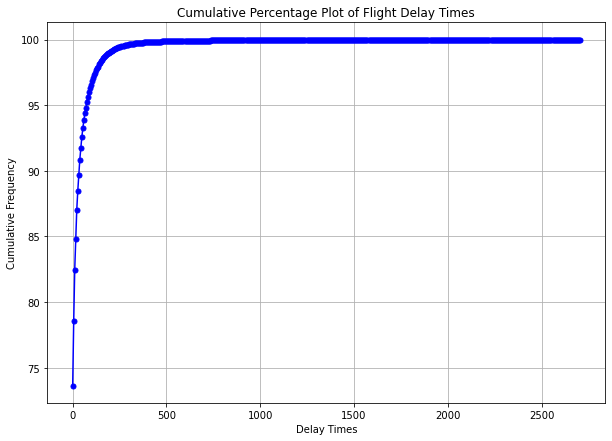

In [154]:
import statsmodels.api as sm

fig = plt.figure(figsize=(10, 7))
delayTimes = pd.DataFrame(raw_data['DEP_DELAY_NEW'][raw_data['DEP_DELAY_NEW'].notna()])
# plt.hist(delayTimes['DEP_DELAY_NEW'], bins = 100)
values, base = np.histogram(delayTimes, bins=500)
cumulative = np.cumsum(values)
cumulative_percentage = 100 * cumulative / cumulative[-1]

plt.plot(base[:-1], cumulative_percentage, c='blue', marker='o', markersize=5, linestyle='-')
plt.title('Ogive')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')
plt.grid(True)

plt.title('Cumulative Percentage Plot of Flight Delay Times')
plt.xlabel('Delay Times')
plt.show()

In [155]:
nan_columns = []
drop_columns = []
for col in raw_data.columns:
    nan_count = raw_data[col].isna().sum()
    percent_nan = (100 * nan_count/len(raw_data))
    # if percent_nan != '0.0':
    #     print(col + ": " + str(percent_nan))
    nan_columns.append((percent_nan, col))
    if percent_nan > 30:
        drop_columns.append(col)
nan_columns.sort(reverse=True)
print("Percent NaN")
print("{} cols with more than 30% NaN:{}".format(len(drop_columns), drop_columns))

for v in nan_columns:
    print(v)

Percent NaN
10 cols with more than 30% NaN:['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'SNOW', 'SNWD', 'PSUN', 'TSUN']
(99.76208226856073, 'TSUN')
(99.75770341460786, 'PSUN')
(98.17626346778286, 'CANCELLATION_CODE')
(81.27950112502863, 'WEATHER_DELAY')
(81.27950112502863, 'SECURITY_DELAY')
(81.27950112502863, 'NAS_DELAY')
(81.27950112502863, 'LATE_AIRCRAFT_DELAY')
(81.27950112502863, 'CARRIER_DELAY')
(41.87453123807043, 'SNWD')
(39.89596292121207, 'SNOW')
(28.034096676113016, 'TAVG')
(16.807164254180122, 'PRCP')
(16.80559235788935, 'TMIN')
(16.79986616425867, 'TMAX')
(16.79189440449832, 'AWND')
(16.78381036643148, 'ORIGIN_AIRPORT_NAME')
(16.37725061865347, 'GROUND_SERV_PER_PASS')
(16.37725061865347, 'FLT_ATTENDANTS_PER_PASS')
(16.37725061865347, 'AVG_MONTHLY_PASS_AIRPORT')
(16.37725061865347, 'AVG_MONTHLY_PASS_AIRLINE')
(16.37725061865347, 'AIRPORT_FLIGHTS_MONTH')
(16.37725061865347, 'AIRLINE_FLIGHTS_MONTH')
(16.37725061

From the code above, we've sorted the columns by the percent of their data values that are NaN. Traditionally we will remove all rows that contain NaN, but if some columns have a large proportion of NaN values we will either (a) drop the column or (b) replace the NaN values with a real value based on some logical, real-world assumtion. This will allow us to data on all columns while maintaining a sizeable data set to run our models. Removing all NaN rows without dropping columns or replacing NaN values would shrink our dataset by at least 99%, as the TSUN and PSUN columns only have 1% of their data values as an non-null value. 

We will now inspect each column that has a NaN percentage greater than 30% to determine if we should either drop the column, or fill NaN values to retain useful data. We'll conduct this analysis for continuous and discrete variables with a scatterplot plotting the variable and the minutes delayed. For categroical variables, we will use a histogram plotting the variable versus the delay time. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


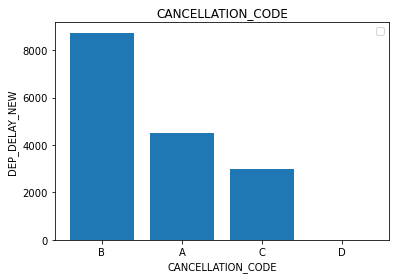

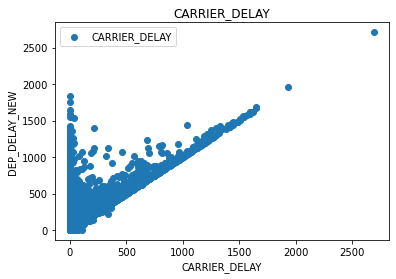

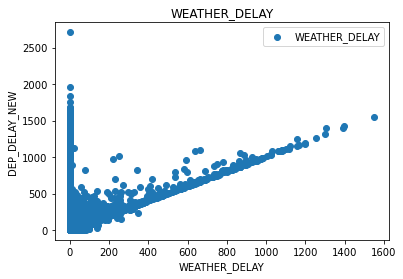

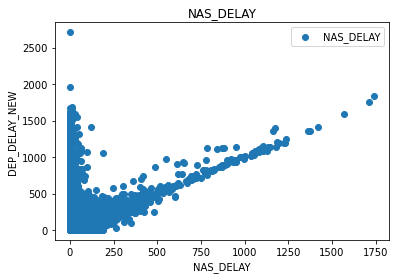

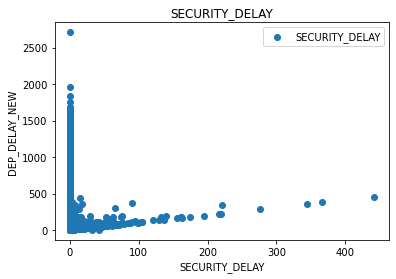

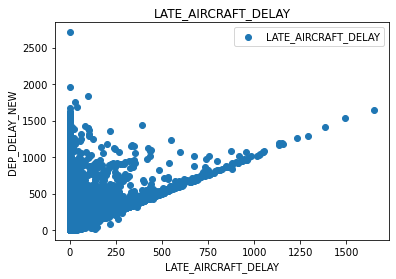

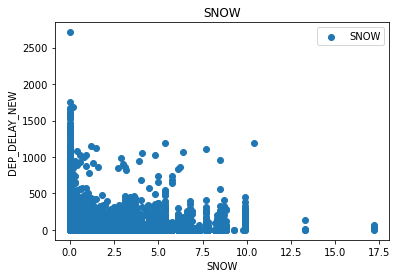

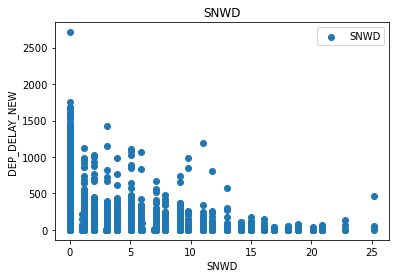

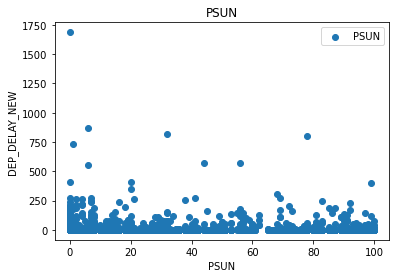

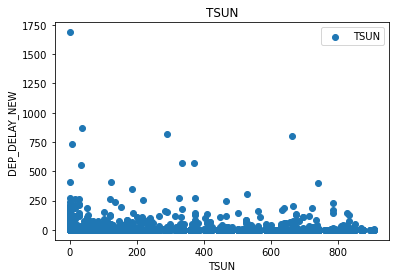

In [156]:
needCharts = True
for col in drop_columns:
    if not needCharts:
        break
    t = type(raw_data[col][5])
    if t == np.int64 or t == np.float64:
        # t = type(cleaned_data[col][5]) 
        # if t == np.float64 or t == np.int64:
        x = raw_data[col]
        y = raw_data['DEP_DELAY_NEW']
        plt.scatter(x, y, label=col)
        
        plt.xlabel(col)
        plt.ylabel('DEP_DELAY_NEW')
        plt.title(col)
        plt.legend()  # Show legend to differentiate between columns
        plt.show()
    else:
        df = raw_data[col].value_counts()
   
        plt.bar(df.index, height=df.values)
        
        plt.xlabel(col)
        plt.ylabel('DEP_DELAY_NEW')
        plt.title(col)
        plt.legend()  # Show legend to differentiate between columns
        plt.show()

From the graphs above, we can see that almost every variable is highly correlated with the delay time of the flight, with the exception of PSUN and TSUN. We'll likley drop PSUN and TSUN given that they do not have a high correlation with the delay time of a flight, which is supported by the fact that sunlight duration has little to do with the factors of flight delays. Also there isn't any rational value to fill in for rows that have a NaN on the PSUN and TSUN columns—for the other columns we can assume the absence of a value can be filled in with a 0. Any possible relations between sunlight and flight delay would be better represented by the precipitation and snowfall metrics.

Given the descriptions of the columns, we can reasonably fill all NaN values for the columns graphed above with 0.0, and create a new class for the cancelation code column.



In [157]:
drop_columns

['CANCELLATION_CODE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'SNOW',
 'SNWD',
 'PSUN',
 'TSUN']

In [158]:
#fill columns, drop TSUN and PSUN
raw_data_2 = raw_data.drop(['TSUN', 'PSUN'], axis = 1)
raw_data_2['CANCELLATION_CODE'] = raw_data_2['CANCELLATION_CODE'].fillna('E')

for col in drop_columns:
    if col not in ['PSUN', 'TSUN', 'CANCELLATION_CODE']:
        raw_data_2[col] = raw_data_2[col].fillna(0.0)

In [159]:
raw_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890644 entries, 0 to 890643
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          890644 non-null  int64  
 1   DAY_OF_MONTH                   890644 non-null  int64  
 2   DAY_OF_WEEK                    890644 non-null  int64  
 3   OP_UNIQUE_CARRIER              890644 non-null  object 
 4   TAIL_NUM                       888500 non-null  object 
 5   OP_CARRIER_FL_NUM              890644 non-null  int64  
 6   ORIGIN_AIRPORT_ID              890644 non-null  int64  
 7   ORIGIN_AIRPORT_NAME            741160 non-null  object 
 8   ORIGIN                         890644 non-null  object 
 9   ORIGIN_CITY_NAME               890644 non-null  object 
 10  DEST_AIRPORT_ID                890644 non-null  int64  
 11  DEST                           890644 non-null  object 
 12  DEST_CITY_NAME                

Now lets re-run the visualizations for the columns that had NaN values replaced to ensure we achieved the effect we wanted.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                   DEP_DELAY_NEW
CANCELLATION_CODE               
A                      68.309211
B                      56.578947
C                      68.736111
D                       0.000000
E                      14.108403


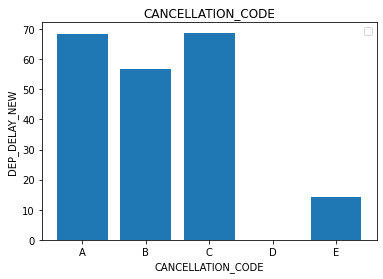

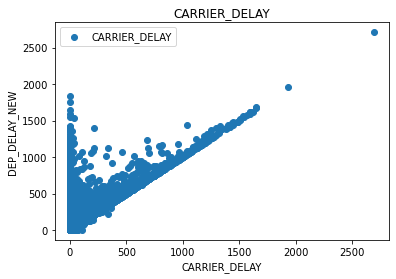

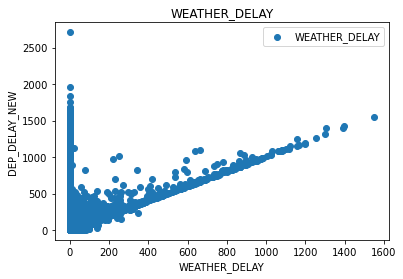

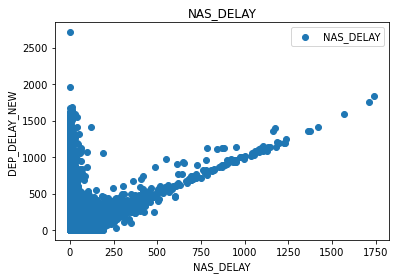

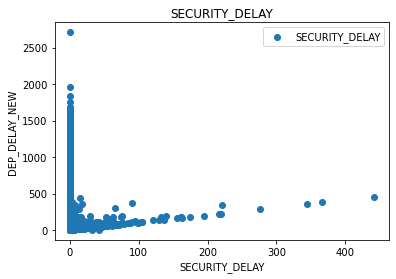

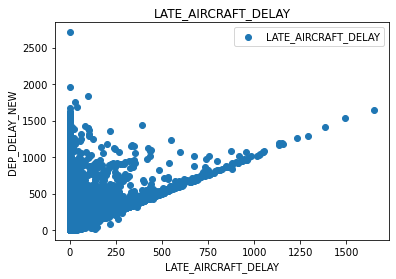

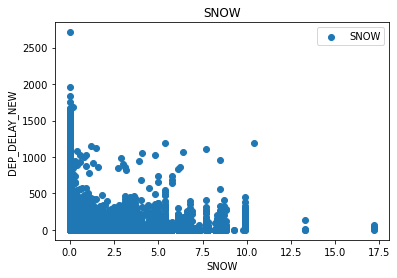

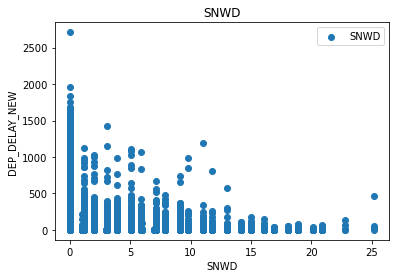

In [160]:
raw_data = raw_data_2
drawGraphs = True



if drawGraphs:
    for col in ['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'SNOW', 'SNWD',]:
        t = type(raw_data[col][5])
        if t == np.int64 or t == np.float64:
            # t = type(cleaned_data[col][5]) 
            # if t == np.float64 or t == np.int64:
            x = raw_data[col]
            y = raw_data['DEP_DELAY_NEW']
            plt.scatter(x, y, label=col)
            
            plt.xlabel(col)
            plt.ylabel('DEP_DELAY_NEW')
            plt.title(col)
            plt.legend()  # Show legend to differentiate between columns
            plt.show()
        else:
            df = raw_data[[col, 'DEP_DELAY_NEW']].groupby([col]).mean()
            print(df)
    
            plt.bar(df.index, height=df['DEP_DELAY_NEW'])
            
            plt.xlabel(col)
            plt.ylabel('DEP_DELAY_NEW')
            plt.title(col)
            plt.legend()  # Show legend to differentiate between columns
            plt.show()
            
raw_data = raw_data_2

It seems like there is a clear correlation between the delay variables and the delay time, which makes sense. There's a counterintuitive correlation between snowfall and delay time, as it seems delay time decreases as snowfall increases. But this may just be a function of there being less data on flights with higher amounts of snowfall, which would reduce the spread of the data as higher deviations become less probable. 

Just to get a better picture of the relationship between the other columns and delayed flight time, we'll graph them below. 

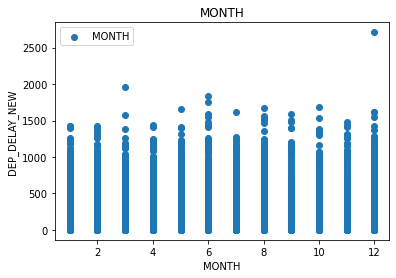

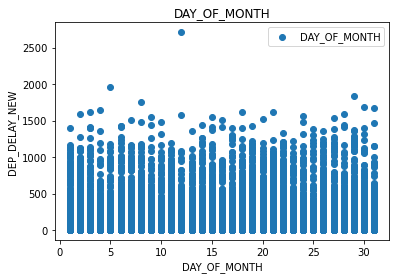

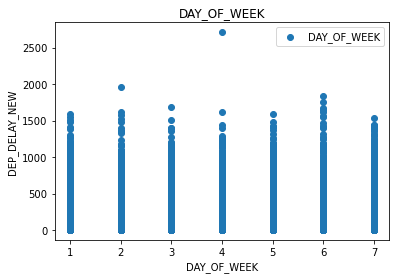

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


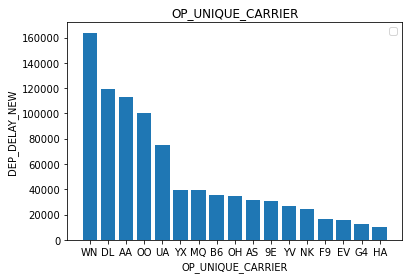

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


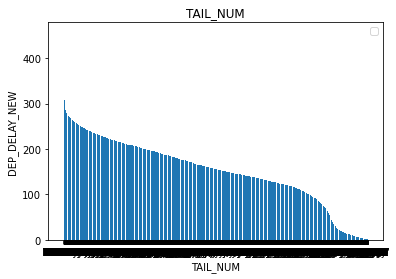

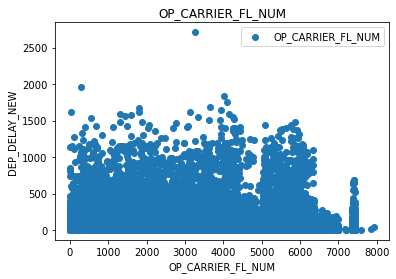

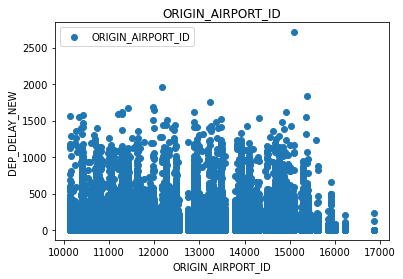

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


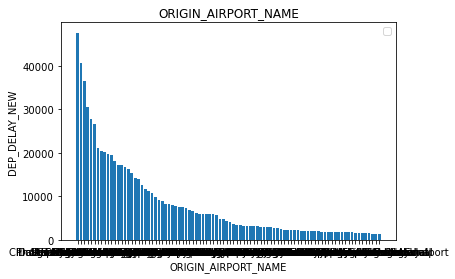

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


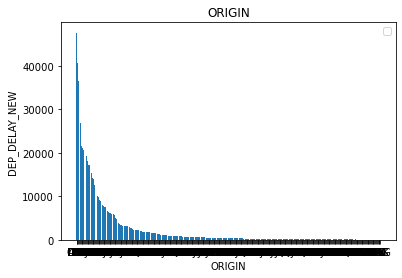

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


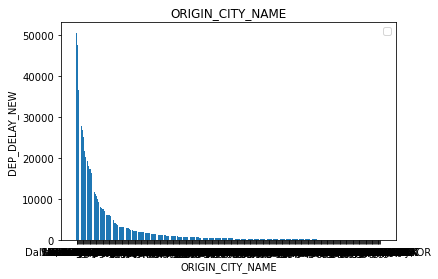

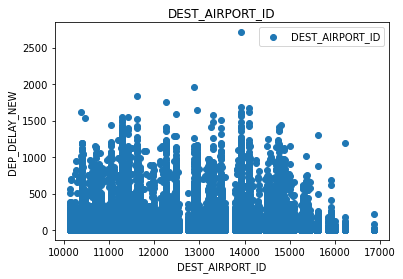

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


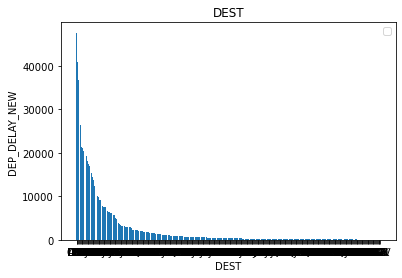

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


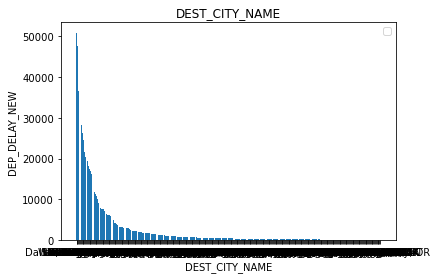

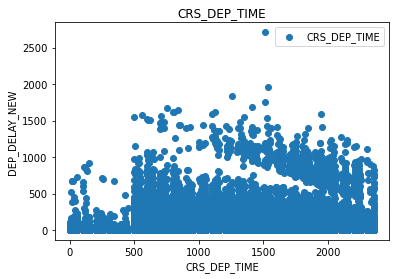

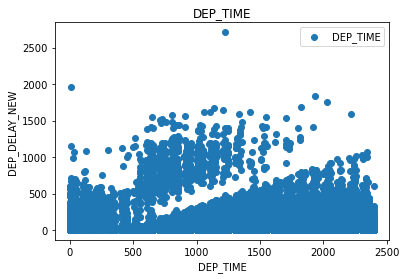

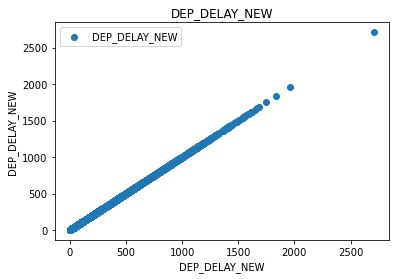

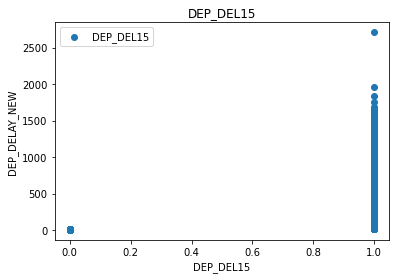

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


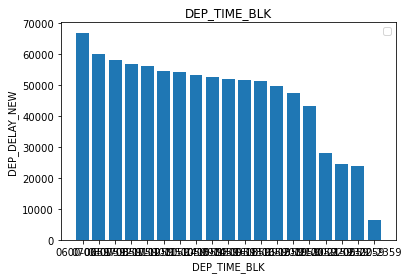

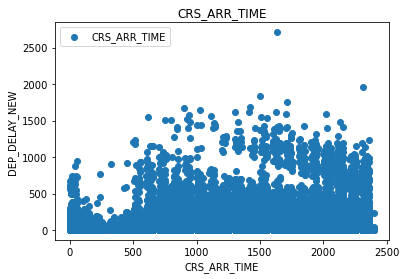

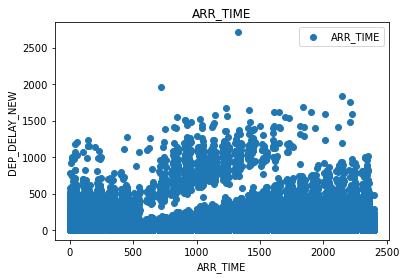

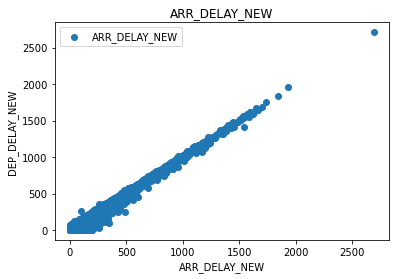

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


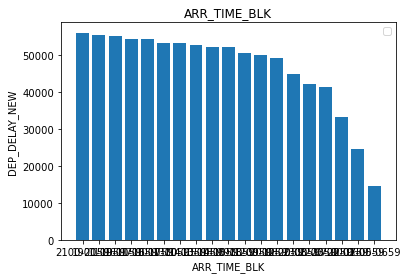

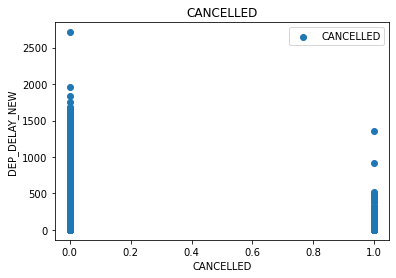

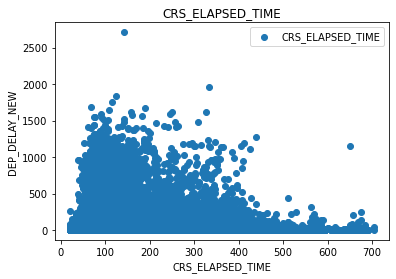

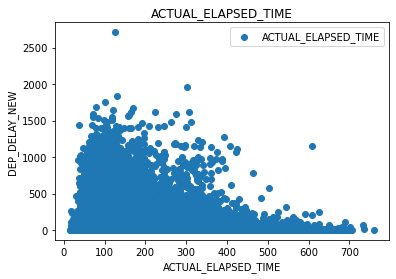

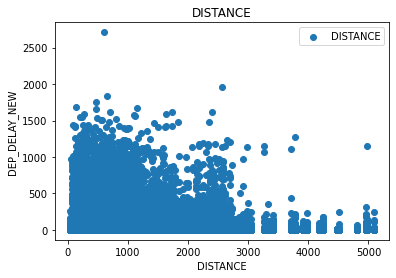

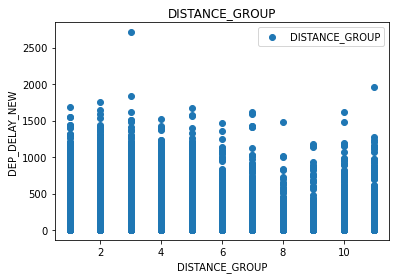

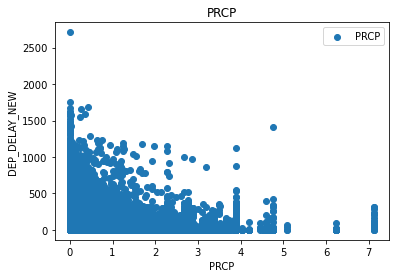

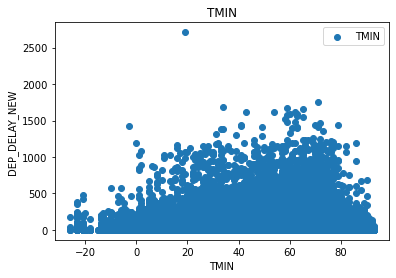

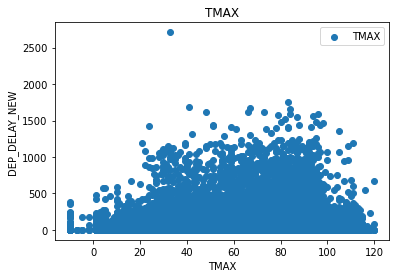

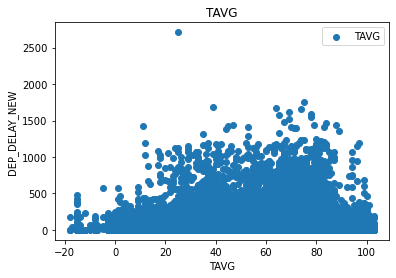

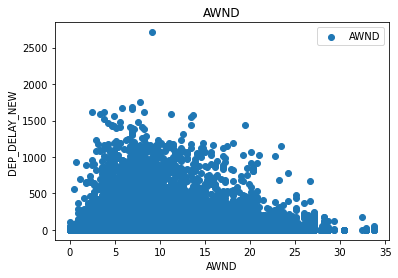

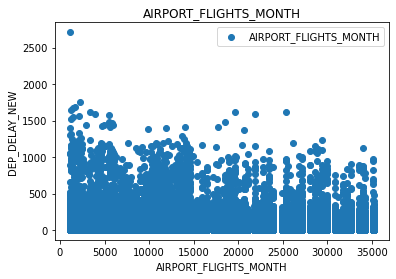

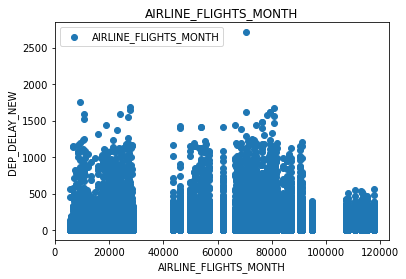

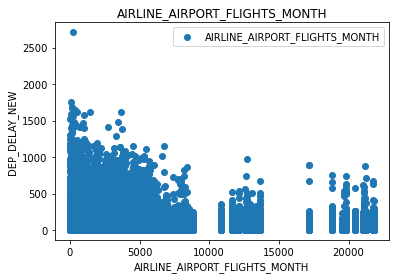

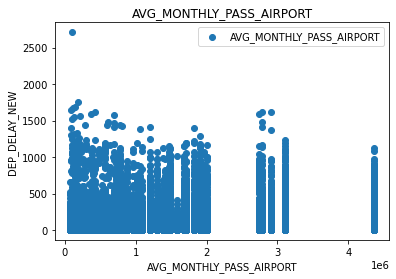

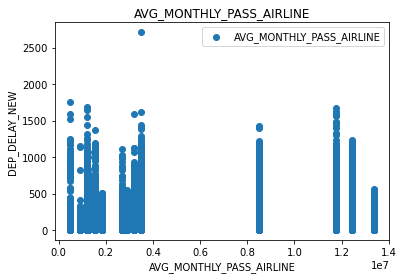

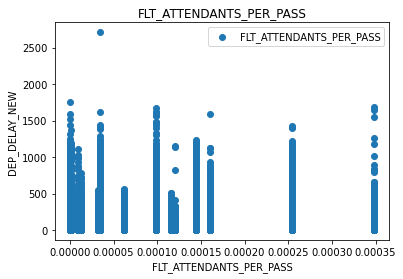

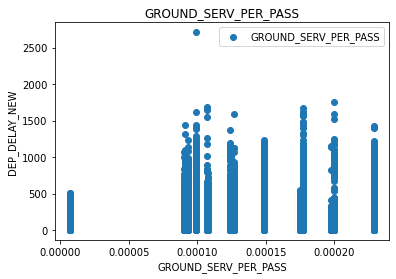

In [161]:
#GRAPHING ALL VARIABLES VERSUS DELAY TIME
shouldGraph = True
if shouldGraph:
    for col in raw_data.columns:
        if col in drop_columns:
            continue
        
        t = type(raw_data[col][5])
        if t == np.int64 or t == np.float64:
            # t = type(cleaned_data[col][5]) 
            # if t == np.float64 or t == np.int64:
            x = raw_data[col]
            y = raw_data['DEP_DELAY_NEW']
            plt.scatter(x, y, label=col)
            
            plt.xlabel(col)
            plt.ylabel('DEP_DELAY_NEW')
            plt.title(col)
            plt.legend()  # Show legend to differentiate between columns
            plt.show()
        else:
            df = raw_data[col].value_counts()
    
            plt.bar(df.index, height=df.values)
            
            plt.xlabel(col)
            plt.ylabel('DEP_DELAY_NEW')
            plt.title(col)
            plt.legend()  # Show legend to differentiate between columns
            plt.show()

In [162]:

cleaned_data = raw_data.dropna(axis = 0)

In [163]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620114 entries, 4 to 890643
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          620114 non-null  int64  
 1   DAY_OF_MONTH                   620114 non-null  int64  
 2   DAY_OF_WEEK                    620114 non-null  int64  
 3   OP_UNIQUE_CARRIER              620114 non-null  object 
 4   TAIL_NUM                       620114 non-null  object 
 5   OP_CARRIER_FL_NUM              620114 non-null  int64  
 6   ORIGIN_AIRPORT_ID              620114 non-null  int64  
 7   ORIGIN_AIRPORT_NAME            620114 non-null  object 
 8   ORIGIN                         620114 non-null  object 
 9   ORIGIN_CITY_NAME               620114 non-null  object 
 10  DEST_AIRPORT_ID                620114 non-null  int64  
 11  DEST                           620114 non-null  object 
 12  DEST_CITY_NAME                

By filling in values for the NaN occurences, we were able to compile a dataset with information on all but two of the original columns with only a 25% reduction in entries. Our next task is to determine which variables are classifiers and which are continuous/discrete and one-hot encode all factor variables into r-1 states where r denotes the number of states in a factor variable. We'll also drop columns that contain redundnat data that are also contained in other columns. 

Upon closer inspection, there seem to be columns that are obviously correlated with delay time as these are metrics collected after the flight has departed and landed. These metrics include actual arrival time and actual elapsed time. Since we want to make predicive models and understand variables which may have causal relationships wtih delay time, we'll drop these columns. 

In [164]:
cleaned_data.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_NAME,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
4,3,21,4,DL,N986AT,2639,14771,San Francisco International,SFO,"San Francisco, CA",12892,LAX,"Los Angeles, CA",1226,1229.0,3.0,0.0,1200-1259,1351,1351.0,0.0,1300-1359,0.0,E,85.0,82.0,337.0,2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,46.0,61.0,53.0,7.61,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149
5,10,25,5,WN,N206WN,8,11259,Dallas Love Field,DAL,"Dallas, TX",11066,CMH,"Columbus, OH",950,956.0,6.0,0.0,0900-0959,1310,1302.0,0.0,1300-1359,0.0,E,140.0,126.0,919.0,4,0.0,0.0,0.0,0.0,0.0,0.42,0.0,0.0,45.0,50.0,50.0,15.88,6261.0,115051.0,5727.0,673221.0,13382999.0,0.000062,0.000099
6,2,1,5,AA,N937AN,168,12889,McCarran International,LAS,"Las Vegas, NV",13930,ORD,"Chicago, IL",1510,1505.0,0.0,0.0,1500-1559,2050,2053.0,3.0,2000-2059,0.0,E,220.0,228.0,1514.0,7,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,44.0,66.0,54.0,3.80,11500.0,70199.0,1059.0,1903352.0,11744595.0,0.000098,0.000177
8,10,29,2,F9,N205FR,244,11292,Stapleton International,DEN,"Denver, CO",12266,IAH,"Houston, TX",2100,2057.0,0.0,0.0,2100-2159,27,33.0,6.0,0001-0559,0.0,E,147.0,156.0,862.0,4,0.0,0.0,0.0,0.0,0.0,0.22,6.6,5.9,7.0,18.0,15.0,12.30,22355.0,12581.0,2616.0,2743323.0,1857122.0,0.000116,0.000007
9,2,19,2,DL,N887DN,505,14869,Salt Lake City International,SLC,"Salt Lake City, UT",13487,MSP,"Minneapolis, MN",1528,1542.0,14.0,0.0,1500-1559,1900,1857.0,0.0,1900-1959,0.0,E,152.0,135.0,991.0,4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,22.0,27.0,26.0,10.74,8345.0,67273.0,3086.0,1065782.0,12460183.0,0.000144,0.000149


In [165]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620114 entries, 4 to 890643
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          620114 non-null  int64  
 1   DAY_OF_MONTH                   620114 non-null  int64  
 2   DAY_OF_WEEK                    620114 non-null  int64  
 3   OP_UNIQUE_CARRIER              620114 non-null  object 
 4   TAIL_NUM                       620114 non-null  object 
 5   OP_CARRIER_FL_NUM              620114 non-null  int64  
 6   ORIGIN_AIRPORT_ID              620114 non-null  int64  
 7   ORIGIN_AIRPORT_NAME            620114 non-null  object 
 8   ORIGIN                         620114 non-null  object 
 9   ORIGIN_CITY_NAME               620114 non-null  object 
 10  DEST_AIRPORT_ID                620114 non-null  int64  
 11  DEST                           620114 non-null  object 
 12  DEST_CITY_NAME                

In [166]:
cleaned_data.describe()
factor_vars = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 
               'ORIGIN', 'DEST',
               ]
cols_to_drop = ['ORIGIN_AIRPORT_NAME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', #reundant cols of origin
                'DEST_CITY_NAME', 'DEST_AIRPORT_ID', #redundant cols of dest
                'TAIL_NUM', 'OP_CARRIER_FL_NUM', #cols that are randomly generated and have no impact on delay time
                'DEP_TIME', 'ARR_TIME', 'CANCELLED', 'ACTUAL_ELAPSED_TIME', #cols that would correlate highly with delay time but are not cols of interest
                'ARR_TIME_BLK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'ARR_DELAY_NEW', 'CANCELLATION_CODE', 
                'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'] #same as above, distance group is redundant col of the discrete distance var


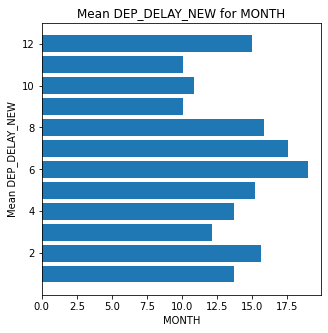

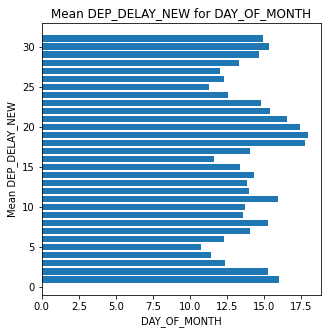

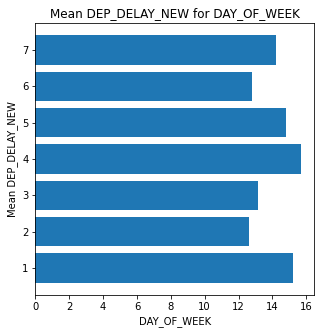

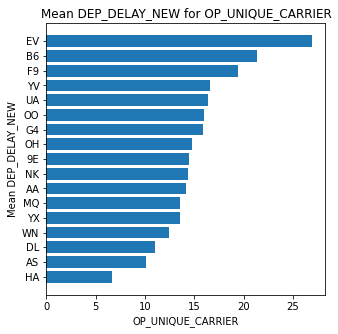

<Figure size 360x360 with 0 Axes>

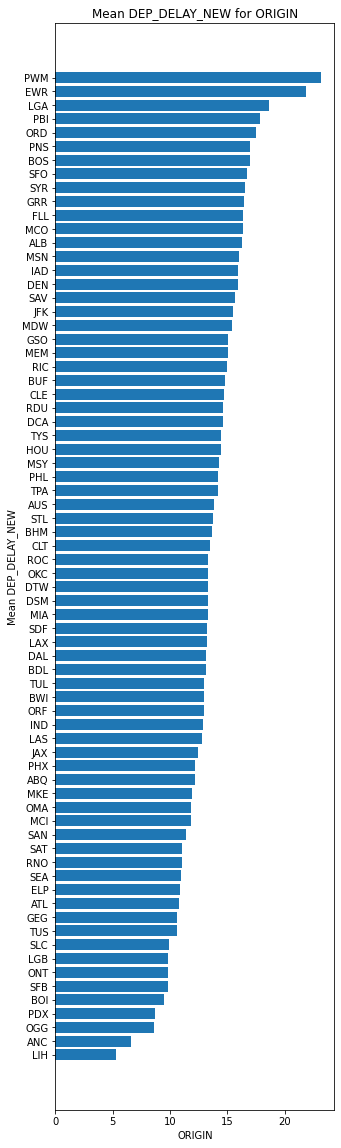

<Figure size 360x360 with 0 Axes>

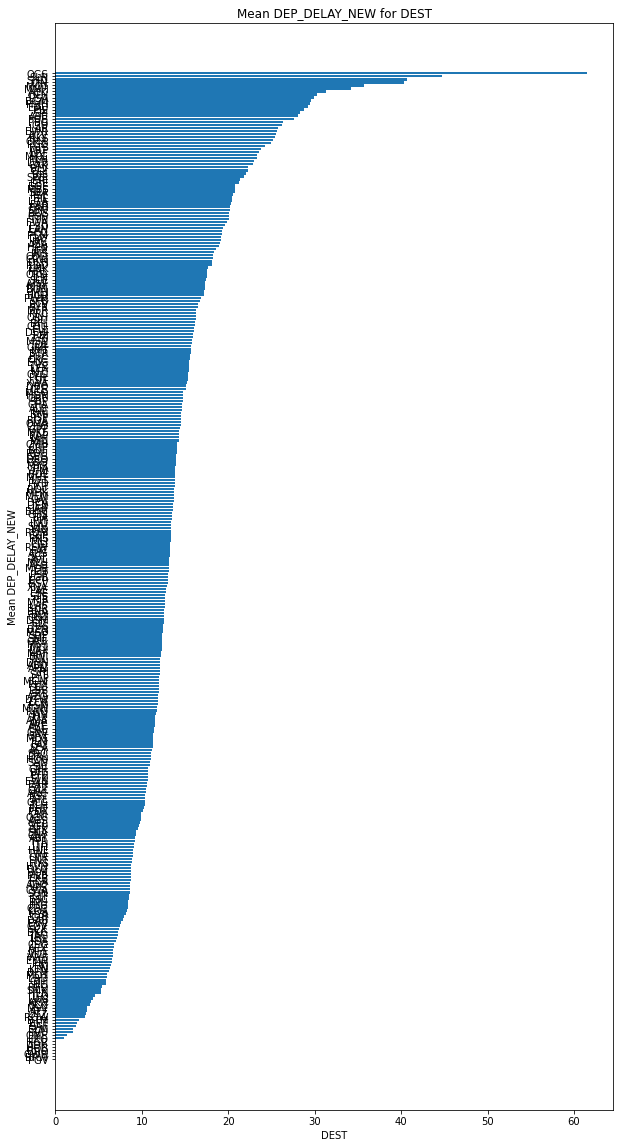

In [167]:
#display value counts of factor vars
#NEED TO TRANSLATE THESE CATEGORICAL FEATURES INTO DISCRETE, ORDINAL VARIABLES, can't one hot encode everything
#for all these categorical variables we will replace the category with the mean delay time for that category
cat_to_num = {}
for col in factor_vars:

    plt.figure(figsize=(5, 5))
    if col == 'ORIGIN':
        plt.figure(figsize=(5, 20))
    elif col == 'DEST':
        plt.figure(figsize=(10, 20))
    means = pd.DataFrame(cleaned_data.groupby(col)['DEP_DELAY_NEW'].mean())
     
    means = means.sort_values(by=['DEP_DELAY_NEW'])
    cat_to_num[col] = means.to_dict()['DEP_DELAY_NEW']
    plt.barh(means.index, means['DEP_DELAY_NEW'])
    
    

    
    plt.title(f'Mean DEP_DELAY_NEW for {col}')
    plt.xlabel(col)
    plt.ylabel('Mean DEP_DELAY_NEW')
    
    plt.show()
    

In [168]:
#drop variables that dont make sense, arrival times
#drop variables that are redundant
all_dropped_data = cleaned_data.drop(cols_to_drop, axis = 1)
all_dropped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620114 entries, 4 to 890643
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          620114 non-null  int64  
 1   DAY_OF_MONTH                   620114 non-null  int64  
 2   DAY_OF_WEEK                    620114 non-null  int64  
 3   OP_UNIQUE_CARRIER              620114 non-null  object 
 4   ORIGIN                         620114 non-null  object 
 5   DEST                           620114 non-null  object 
 6   CRS_DEP_TIME                   620114 non-null  int64  
 7   DEP_DELAY_NEW                  620114 non-null  float64
 8   DEP_DEL15                      620114 non-null  float64
 9   CRS_ARR_TIME                   620114 non-null  int64  
 10  CRS_ELAPSED_TIME               620114 non-null  float64
 11  DISTANCE                       620114 non-null  float64
 12  PRCP                          

In [169]:
refactored_data = pd.DataFrame()


for col in factor_vars:
    dic = cat_to_num.get(col)

    series = all_dropped_data[col]
    new_series = []
    for v in all_dropped_data[col]:
        new = dic.get(v)
        
        new_series.append(new)
    
    new_series = np.array(new_series)
    
    refactored_data["Refact_" + col] = new_series
    refactored_data.index = all_dropped_data.index
    
prefinal_data = pd.concat([refactored_data, all_dropped_data], axis = 1)
prefinal_data = prefinal_data.drop(factor_vars, axis = 1)
prefinal_data.info()
        
    
    
    
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620114 entries, 4 to 890643
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Refact_MONTH                   620114 non-null  float64
 1   Refact_DAY_OF_MONTH            620114 non-null  float64
 2   Refact_DAY_OF_WEEK             620114 non-null  float64
 3   Refact_OP_UNIQUE_CARRIER       620114 non-null  float64
 4   Refact_ORIGIN                  620114 non-null  float64
 5   Refact_DEST                    620114 non-null  float64
 6   CRS_DEP_TIME                   620114 non-null  int64  
 7   DEP_DELAY_NEW                  620114 non-null  float64
 8   DEP_DEL15                      620114 non-null  float64
 9   CRS_ARR_TIME                   620114 non-null  int64  
 10  CRS_ELAPSED_TIME               620114 non-null  float64
 11  DISTANCE                       620114 non-null  float64
 12  PRCP                          

In [170]:
# temp_df = all_dropped_data.drop(factor_vars, axis = 1) #drop factor variables
final_data = prefinal_data
print("Converted {} factor vars to {} numerical variables".format(len(factor_vars), len(factor_vars)))
print("Factor Vars: {}".format(factor_vars))

Converted 6 factor vars to 6 numerical variables
Factor Vars: ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']


In [171]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620114 entries, 4 to 890643
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Refact_MONTH                   620114 non-null  float64
 1   Refact_DAY_OF_MONTH            620114 non-null  float64
 2   Refact_DAY_OF_WEEK             620114 non-null  float64
 3   Refact_OP_UNIQUE_CARRIER       620114 non-null  float64
 4   Refact_ORIGIN                  620114 non-null  float64
 5   Refact_DEST                    620114 non-null  float64
 6   CRS_DEP_TIME                   620114 non-null  int64  
 7   DEP_DELAY_NEW                  620114 non-null  float64
 8   DEP_DEL15                      620114 non-null  float64
 9   CRS_ARR_TIME                   620114 non-null  int64  
 10  CRS_ELAPSED_TIME               620114 non-null  float64
 11  DISTANCE                       620114 non-null  float64
 12  PRCP                          

In [172]:
final_data.head(20)

,Refact_MONTH,Refact_DAY_OF_MONTH,Refact_DAY_OF_WEEK,Refact_OP_UNIQUE_CARRIER,Refact_ORIGIN,Refact_DEST,CRS_DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
4,12.182613,16.534128,15.705022,11.020963,16.749210,12.278054,1226,3.0,0.0,1351,85.0,337.0,0.00,0.0,0.0,46.0,61.0,53.0,7.61,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149
5,10.910723,11.293329,14.827057,12.396002,13.172729,14.101160,950,6.0,0.0,1310,140.0,919.0,0.42,0.0,0.0,45.0,50.0,50.0,15.88,6261.0,115051.0,5727.0,673221.0,13382999.0,0.000062,0.000099
6,15.655559,16.030375,14.827057,14.172671,12.794254,17.529299,1510,0.0,0.0,2050,220.0,1514.0,0.00,0.0,0.0,44.0,66.0,54.0,3.80,11500.0,70199.0,1059.0,1903352.0,11744595.0,0.000098,0.000177
8,10.910723,14.653492,12.625661,19.419245,15.939545,14.306413,2100,0.0,0.0,27,147.0,862.0,0.22,6.6,5.9,7.0,18.0,15.0,12.30,22355.0,12581.0,2616.0,2743323.0,1857122.0,0.000116,0.000007
9,15.655559,17.929581,12.625661,11.020963,9.941939,12.713454,1528,14.0,0.0,1900,152.0,991.0,0.00,0.0,0.0,22.0,27.0,26.0,10.74,8345.0,67273.0,3086.0,1065782.0,12460183.0,0.000144,0.000149
10,10.910723,15.391774,12.625661,12.396002,12.223842,11.020468,1725,0.0,0.0,2140,135.0,879.0,0.00,0.0,0.0,59.0,90.0,75.0,4.03,14630.0,115051.0,5242.0,1827202.0,13382999.0,0.000062,0.000099
12,17.614274,15.261063,12.625661,15.945316,9.941939,13.036437,2025,0.0,0.0,2112,107.0,541.0,0.00,0.0,0.0,69.0,96.0,84.0,12.08,10124.0,72721.0,3603.0,1065782.0,3472966.0,0.000034,0.000099
13,15.210032,14.077895,14.827057,12.396002,13.172729,12.319476,1745,13.0,0.0,1920,95.0,461.0,0.00,0.0,0.0,70.0,87.0,78.0,12.08,5794.0,113709.0,5333.0,673221.0,13382999.0,0.000062,0.000099
15,19.000374,14.653492,12.801698,11.020963,10.804751,12.998099,920,0.0,0.0,925,65.0,240.0,0.03,0.0,0.0,72.0,87.0,80.0,4.92,33994.0,87183.0,21122.0,4365661.0,12460183.0,0.000144,0.000149
16,15.872458,14.343641,13.163026,11.020963,15.939545,11.297914,624,0.0,0.0,818,174.0,1024.0,0.00,0.0,0.0,55.0,93.0,72.0,10.51,23099.0,91062.0,1094.0,2743323.0,12460183.0,0.000144,0.000149


In [173]:
final_data

,Refact_MONTH,Refact_DAY_OF_MONTH,Refact_DAY_OF_WEEK,Refact_OP_UNIQUE_CARRIER,Refact_ORIGIN,Refact_DEST,CRS_DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
4,12.182613,16.534128,15.705022,11.020963,16.749210,12.278054,1226,3.0,0.0,1351,85.0,337.0,0.00,0.0,0.0,46.0,61.0,53.0,7.61,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149
5,10.910723,11.293329,14.827057,12.396002,13.172729,14.101160,950,6.0,0.0,1310,140.0,919.0,0.42,0.0,0.0,45.0,50.0,50.0,15.88,6261.0,115051.0,5727.0,673221.0,13382999.0,0.000062,0.000099
6,15.655559,16.030375,14.827057,14.172671,12.794254,17.529299,1510,0.0,0.0,2050,220.0,1514.0,0.00,0.0,0.0,44.0,66.0,54.0,3.80,11500.0,70199.0,1059.0,1903352.0,11744595.0,0.000098,0.000177
8,10.910723,14.653492,12.625661,19.419245,15.939545,14.306413,2100,0.0,0.0,27,147.0,862.0,0.22,6.6,5.9,7.0,18.0,15.0,12.30,22355.0,12581.0,2616.0,2743323.0,1857122.0,0.000116,0.000007
9,15.655559,17.929581,12.625661,11.020963,9.941939,12.713454,1528,14.0,0.0,1900,152.0,991.0,0.00,0.0,0.0,22.0,27.0,26.0,10.74,8345.0,67273.0,3086.0,1065782.0,12460183.0,0.000144,0.000149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890639,10.059551,14.653492,14.827057,11.020963,13.306095,16.014940,1229,0.0,0.0,1527,178.0,1127.0,0.00,0.0,0.0,32.0,38.0,35.0,4.92,13199.0,79989.0,4894.0,1486066.0,12460183.0,0.000144,0.000149
890640,15.872458,12.318166,15.230647,16.335918,10.591371,17.529299,2340,0.0,0.0,507,207.0,1498.0,0.00,0.0,0.0,56.0,79.0,67.0,4.25,1162.0,55706.0,88.0,162026.0,8501631.0,0.000254,0.000229
890641,17.614274,15.391774,15.230647,11.020963,16.956970,18.579174,1558,332.0,1.0,1730,92.0,187.0,0.85,0.0,0.0,67.0,84.0,81.0,11.41,12603.0,90457.0,1635.0,1472200.0,12460183.0,0.000144,0.000149
890642,10.059551,14.052764,15.705022,12.396002,13.172729,14.101160,1605,0.0,0.0,1920,135.0,919.0,0.64,0.0,0.0,43.0,71.0,59.0,11.41,5954.0,108130.0,5542.0,673221.0,13382999.0,0.000062,0.000099


In [174]:
final_data.to_csv('/Users/arjunarasappan/Documents/Projects/WAF Technical/final_data.csv')